### Import Libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [2]:
import re
import string
from string import punctuation
from collections import Counter

import nltk
from nltk.corpus import stopwords
from nltk.tokenize import TweetTokenizer
from nltk.stem.wordnet import WordNetLemmatizer
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer

In [3]:
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\lm_pa\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [4]:
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score, KFold, cross_val_score, GridSearchCV 

from sklearn.svm import SVC
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier 
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.neural_network import MLPClassifier

from sklearn.metrics import classification_report, plot_confusion_matrix, make_scorer, accuracy_score, f1_score, confusion_matrix, roc_auc_score, recall_score, precision_score, log_loss

In [5]:
import warnings
warnings.simplefilter(action = 'ignore', category= FutureWarning)

### Load the Dataset

In [6]:
# Read a comma-separated values (csv) file into DataFrame.
df = pd.read_csv("dataset.csv", encoding='ANSI', usecols=['tweet', 'sentiment', 'depression_score'])
print(df.shape)

# display first five data records.
df.head()

(1500, 3)


,tweet,sentiment,depression_score
0,I've just posted a new blog: RED alert: Cyclon...,0,0.0
1,Must see series! I cried my eyes out while bin...,0,0.0
2,Depression is really getting on my nerves. I a...,1,0.8
3,dealing with the debts of depression and tryin...,1,0.5
4,i have depression,1,0.5


### Data Pre-processing

In [7]:
# Return a translation table usable for str.translate()
df['tweet'] = df['tweet'].str.translate(str.maketrans('','', string.punctuation))

In [8]:
# Based on depression score creating a new categorical feature. 
df['depression_level'] = df['depression_score'].apply(lambda x: 'No depression' if x == 0 else('Minimal depression' if 0 < x <= 0.2 else('Mild depression' if 0.3 <= x <= 0.55 else('Moderate depression' if 0.6 <= x <= 0.7 else 'Severe depression'))))

In [9]:
# function to clean tweets
def processTweet(tweet):
    # Remove HTML special entities (e.g. &amp;)
    tweet = re.sub(r'\&\w*;', '', tweet)
    #Convert @username to AT_USER
    tweet = re.sub('@[^\s]+','',tweet)
    # Remove tickers
    tweet = re.sub(r'\$\w*', '', tweet)
    # To lowercase
    tweet = tweet.lower()
    # Remove
    tweet = re.sub(r'\€\w*','', tweet)
    tweet = re.sub(r'\€™\w*','', tweet)
    tweet = re.sub(r'\â€¦\w*','', tweet)
    tweet = re.sub(r'\€¦\w*','', tweet)
    tweet = re.sub(r'\¦\w*','', tweet)
    tweet = re.sub(r'\™\w*','', tweet)
    # Remove hyperlinks
    tweet = re.sub(r'https?:\/\/.*\/\w*', '', tweet)
    # Remove hashtags
    tweet = re.sub(r'#\w*', '', tweet)
    # Remove words with 2 or fewer letters
    tweet = re.sub(r'\b\w{1,2}\b', '', tweet)
    # Remove whitespace (including new line characters)
    tweet = re.sub(r'\s\s+', ' ', tweet)
    # Remove single space remaining at the front of the tweet.
    tweet = tweet.lstrip(' ') 
    # Remove characters beyond Basic Multilingual Plane (BMP) of Unicode:
    tweet = ''.join(c for c in tweet if c <= '\uFFFF') 
    return tweet

# storing the processed tweets in new feature.
df['text'] = df['tweet'].apply(processTweet)

In [10]:
# tokenize function
def text_process(raw_text):
    """
    Takes in a string of text, then performs the following:
    1. Remove all punctuation
    2. Remove all stopwords
    3. Returns a list of the cleaned text
    """
    # Check characters to see if they are in punctuation
    nopunc = [char for char in list(raw_text) if char not in string.punctuation]
    # Join the characters again to form the string.
    nopunc = ''.join(nopunc)
    
    # Now just remove any stopwords
    return [word for word in nopunc.lower().split() if word.lower() not in stopwords.words('english')]


In [11]:
# create a column for tokens
df['tokens'] = df['text'].apply(text_process) 

In [12]:
df.head()

,tweet,sentiment,depression_score,depression_level,text,tokens
0,Ive just posted a new blog RED alert Cyclone I...,0,0.0,No depression,ive just posted new blog red alert cyclone ida...,"[ive, posted, new, blog, red, alert, cyclone, ..."
1,Must see series I cried my eyes out while bing...,0,0.0,No depression,must see series cried eyes out while bingewatc...,"[must, see, series, cried, eyes, bingewatching..."
2,Depression is really getting on my nerves I am...,1,0.8,Severe depression,depression really getting nerves having diffic...,"[depression, really, getting, nerves, difficul..."
3,dealing with the debts of depression and tryin...,1,0.5,Mild depression,dealing with the debts depression and trying g...,"[dealing, debts, depression, trying, get, back]"
4,i have depression,1,0.5,Mild depression,have depression,[depression]


### Exploratory Data Analysis

In [13]:
# split sentences to get individual words

all_words = []
for line in list(df['text']):
    words = line.split()
    for word in words:
        all_words.append(word.lower())
        
all_words = []
for line in df['tokens']:
    all_words.extend(line)
    
    for word in words:
        all_words.append(word.lower())

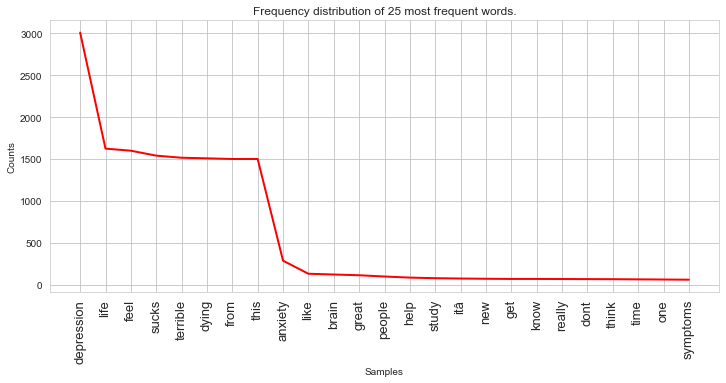

In [14]:
# plot word frequency distribution of first 25 words
sns.set_style('whitegrid')
plt.figure(figsize=(12,5))
plt.xticks(fontsize=13)
plt.title('Frequency distribution of 25 most frequent words.')
fd = nltk.FreqDist(all_words)
fd.plot(25,cumulative=False, color='r')

In [15]:
# create a word frequency dictionary
wordfreq = Counter(all_words)

In [19]:
#!pip install wordcloud

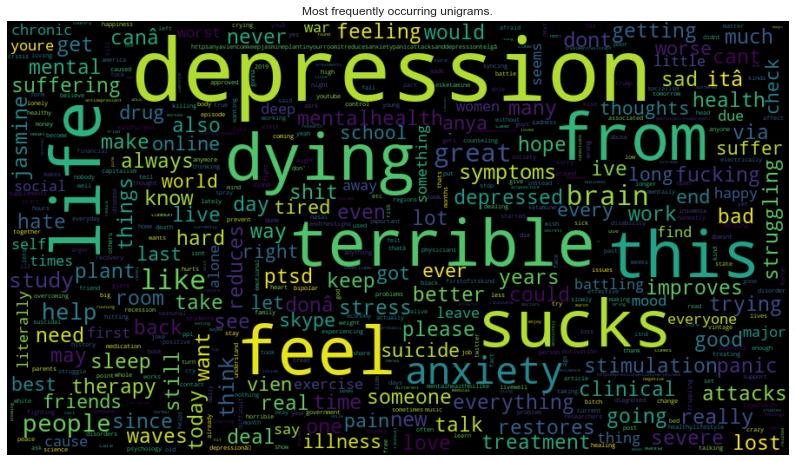

In [20]:
# draw a Word Cloud (Unigram) with word frequencies
from wordcloud import WordCloud
wordcloud = WordCloud(width=900,
                      height=500,
                      max_words=500,
                      max_font_size=100,
                      relative_scaling=0.5,
                      colormap='viridis',
                      normalize_plurals=True).generate_from_frequencies(wordfreq)
plt.figure(figsize=(14,10))
plt.imshow(wordcloud, interpolation='bilinear')
plt.title('Most frequently occurring unigrams.')
plt.axis("off")
plt.show()

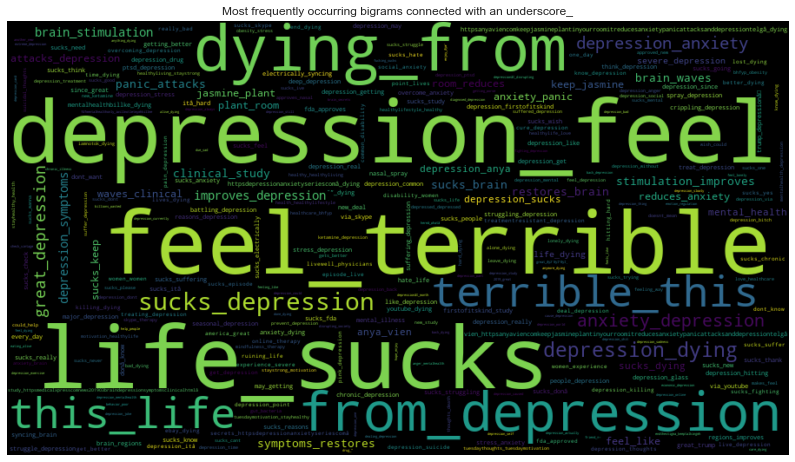

In [325]:
#bigrams
import collections
from nltk.util import ngrams
from operator import itemgetter
from nltk.collocations import BigramAssocMeasures, BigramCollocationFinder

Bigrams = ngrams(all_words, 2)
BigramFreq = collections.Counter(Bigrams)

# setup and score the bigrams using the raw frequency.
finder = BigramCollocationFinder.from_words(all_words)
bigram_measures = BigramAssocMeasures()
scored = finder.score_ngrams(bigram_measures.raw_freq)
 
# By default finder.score_ngrams is sorted, however don't rely on this default behavior.
# Sort highest to lowest based on the score.
scoredList = sorted(scored, key=itemgetter(1), reverse=True)
 
# word_dict is the dictionary we'll use for the word cloud.
# Load dictionary with the FOR loop below.
# The dictionary will look like this with the bigram and the score from above.
 
word_dict = {}
listLen = len(scoredList)
 
# Get the bigram and make a contiguous string for the dictionary key. 
# Set the key to the scored value. 
for i in range(listLen):
    word_dict['_'.join(scoredList[i][0])] = scoredList[i][1]
 
# Set word cloud params and instantiate the word cloud.
# The height and width only affect the output image file.
WC_height = 500
WC_width = 1000
WC_max_words = 100
 
wordCloud = WordCloud(width=900,
                      height=500,
                      max_words=500,
                      max_font_size=100,
                      relative_scaling=0.5,
                      colormap='viridis',
                      normalize_plurals=True)
 
wordCloud.generate_from_frequencies(word_dict)

plt.figure(figsize=(14,10)) 
plt.title('Most frequently occurring bigrams connected with an underscore_')
plt.imshow(wordCloud, interpolation='bilinear')
plt.axis("off")
plt.show()

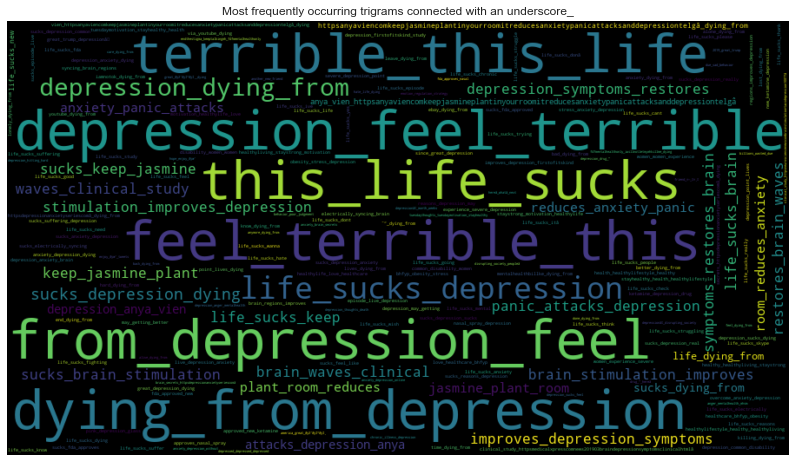

In [326]:
from nltk.collocations import TrigramAssocMeasures, TrigramCollocationFinder

#trigrams
Trigrams = ngrams(all_words, 3)
TrigramFreq = collections.Counter(Trigrams)

# setup and score the trigrams using the raw frequency.
finder = TrigramCollocationFinder.from_words(all_words)
trigram_measures = TrigramAssocMeasures()
scored = finder.score_ngrams(trigram_measures.raw_freq)

scoredList = sorted(scored, key=itemgetter(1), reverse=True)
 
# word_dict is the dictionary we'll use for the word cloud.
# Load dictionary with the FOR loop below.
# The dictionary will look like this with the trigram and the score from above.
word_dict = {}
listLen = len(scoredList)
 
# Get the trigram and make a contiguous string for the dictionary key. 
# Set the key to the scored value. 
for i in range(listLen):
    word_dict['_'.join(scoredList[i][0])] = scoredList[i][1]

# Set word cloud params and instantiate the word cloud.
# The height and width only affect the output image file.
WC_height = 500
WC_width = 1000
WC_max_words = 100
 
wordCloud = WordCloud(width=900,
                      height=500,
                      max_words=500,
                      max_font_size=100,
                      relative_scaling=0.5,
                      colormap='viridis',
                      normalize_plurals=True)
 
wordCloud.generate_from_frequencies(word_dict)

plt.figure(figsize=(14,10)) 
plt.title('Most frequently occurring trigrams connected with an underscore_')
plt.imshow(wordCloud, interpolation='bilinear')
plt.axis("off")
plt.show()

### Train-Test Split

In [327]:
# We split the data into training and testing set (70:30).
X_train, X_test, y_train, y_test = train_test_split(df['text'], df['sentiment'], test_size=0.30, random_state=42)

### Vectorization

In [328]:
# vectorize
bow_transformer = CountVectorizer(analyzer=text_process)

In [329]:
X_train = bow_transformer.fit_transform(X_train)
X_test = bow_transformer.transform(X_test)

In [330]:
#Term Frequency, Inverse Document Frequency
from sklearn.feature_extraction.text import TfidfTransformer
tfidf_transformer = TfidfTransformer()

In [331]:
X_train = tfidf_transformer.fit_transform(X_train)
X_test = tfidf_transformer.transform(X_test)

### Model Training and Evaluation

Support Vector Classifier

In [332]:
# We are going to use cross validation and grid search to find good hyperparameters for our model. We need to build a pipeline to don't get features from the validation folds when building each training model.
clfs = []
kfolds = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

#Support Vector Machine(SVM)
grid_svm = GridSearchCV(estimator = SVC(probability=True, class_weight="balanced", random_state=42),
                    param_grid = {'C': [0.01, 0.1, 1]}, 
                    cv = kfolds, verbose=1) 

grid_svm.fit(X_train, y_train)

svm = grid_svm.predict(X_test)

print(confusion_matrix(y_test, svm))
print('\n')
print(classification_report(y_test, svm))

clfs.append(grid_svm)

Fitting 5 folds for each of 3 candidates, totalling 15 fits
[[206  33]
 [ 10 201]]


              precision    recall  f1-score   support

           0       0.95      0.86      0.91       239
           1       0.86      0.95      0.90       211

    accuracy                           0.90       450
   macro avg       0.91      0.91      0.90       450
weighted avg       0.91      0.90      0.90       450



Multinomial Naive Bayes(NB) 

In [333]:
# this is where we define the values for GridSearchCV to iterate over
parameters = {
              'alpha': (1e-2, 1e-3),
             }
# k-fold cross validation
grid_NB = GridSearchCV(MultinomialNB(), cv=kfolds, param_grid=parameters, verbose=1)
grid_NB.fit(X_train,y_train)

mnb = grid_NB.predict(X_test)

print(confusion_matrix(y_test, mnb))
print('\n')
print(classification_report(y_test, mnb))

clfs.append(grid_NB)

Fitting 5 folds for each of 2 candidates, totalling 10 fits
[[203  36]
 [ 21 190]]


              precision    recall  f1-score   support

           0       0.91      0.85      0.88       239
           1       0.84      0.90      0.87       211

    accuracy                           0.87       450
   macro avg       0.87      0.87      0.87       450
weighted avg       0.88      0.87      0.87       450



Logistic Regression(LR)

In [334]:
# Logistic Regression(LR)
grid_LR = GridSearchCV(LogisticRegression(random_state=42), cv=kfolds, param_grid={'C': [0.01, 0.1, 1]}, verbose=1)
grid_LR.fit(X_train,y_train)

lr = grid_LR.predict(X_test)

print(confusion_matrix(y_test, lr))
print('\n')
print(classification_report(y_test, lr))

clfs.append(grid_LR)

Fitting 5 folds for each of 3 candidates, totalling 15 fits
[[209  30]
 [ 15 196]]


              precision    recall  f1-score   support

           0       0.93      0.87      0.90       239
           1       0.87      0.93      0.90       211

    accuracy                           0.90       450
   macro avg       0.90      0.90      0.90       450
weighted avg       0.90      0.90      0.90       450



Random Forest(RF)

In [335]:
# Random Forest(RF)
grid_RF = RandomForestClassifier(random_state=42,  n_estimators=40)
grid_RF.fit(X_train,y_train)

rf = grid_RF.predict(X_test)

print(confusion_matrix(y_test, rf))
print('\n')
print(classification_report(y_test, rf))

clfs.append(grid_RF)

[[175  64]
 [ 15 196]]


              precision    recall  f1-score   support

           0       0.92      0.73      0.82       239
           1       0.75      0.93      0.83       211

    accuracy                           0.82       450
   macro avg       0.84      0.83      0.82       450
weighted avg       0.84      0.82      0.82       450



Gradient Boosting

In [336]:
Gradient_boosting = GradientBoostingClassifier(learning_rate=0.15, random_state=42, n_estimators=200)
Gradient_boosting.fit(X_train,y_train)

gb = Gradient_boosting.predict(X_test)

print(confusion_matrix(y_test, gb))
print('\n')
print(classification_report(y_test, gb))

clfs.append(Gradient_boosting)

[[178  61]
 [ 26 185]]


              precision    recall  f1-score   support

           0       0.87      0.74      0.80       239
           1       0.75      0.88      0.81       211

    accuracy                           0.81       450
   macro avg       0.81      0.81      0.81       450
weighted avg       0.82      0.81      0.81       450



Multilayer Perceptron

[[209  30]
 [ 11 200]]


              precision    recall  f1-score   support

           0       0.95      0.87      0.91       239
           1       0.87      0.95      0.91       211

    accuracy                           0.91       450
   macro avg       0.91      0.91      0.91       450
weighted avg       0.91      0.91      0.91       450



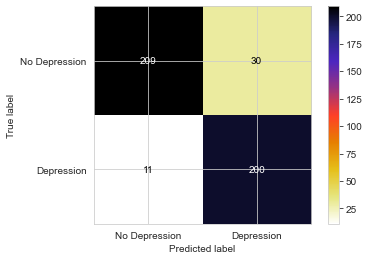

In [337]:
from sklearn.neural_network import MLPClassifier

mlpc = MLPClassifier(hidden_layer_sizes=(200,), early_stopping=True, learning_rate='adaptive', random_state=42)
mlpc.fit(X_train, y_train)

mlp = mlpc.predict(X_test)

plot_confusion_matrix(mlpc, X_test, y_test, cmap='CMRmap_r', display_labels=['No Depression', 'Depression'])

print(confusion_matrix(y_test, mlp))
print('\n')
print(classification_report(y_test, mlp))

clfs.append(mlpc)

In [338]:
# saving the best model
import pickle
pickle_out=open("mlpc.pkl", "wb")
pickle.dump(mlpc, pickle_out)
pickle_out.close()

Mjority Voting Classifier

Fitting 5 folds for each of 3 candidates, totalling 15 fits
Fitting 5 folds for each of 2 candidates, totalling 10 fits
Fitting 5 folds for each of 3 candidates, totalling 15 fits
[[199  40]
 [  7 204]]


              precision    recall  f1-score   support

           0       0.97      0.83      0.89       239
           1       0.84      0.97      0.90       211

    accuracy                           0.90       450
   macro avg       0.90      0.90      0.90       450
weighted avg       0.91      0.90      0.90       450

ROC-AUC Score: 0.9


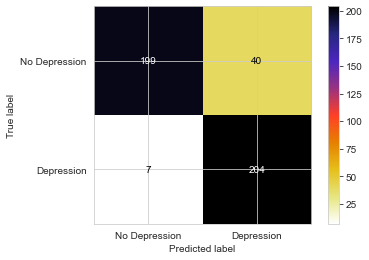

In [339]:
# create a dictionary of our models
estimators=[('svm', grid_svm), ('nb', grid_NB), ('lr', grid_LR), ('rf', grid_RF),
            ('gradient_boosting', Gradient_boosting),('mlp', mlpc)]


#create voting classifier
majority_voting = VotingClassifier(estimators, voting='soft')

majority_voting.fit(X_train, y_train)

plot_confusion_matrix(majority_voting, X_test, y_test, cmap='CMRmap_r', display_labels=['No Depression', 'Depression'])

majority_voting_predictions = majority_voting.predict(X_test)

print(confusion_matrix(y_test, majority_voting_predictions))
print('\n')
print(classification_report(y_test, majority_voting_predictions))

y_probas_mv = majority_voting.predict(X_test)

print('ROC-AUC Score:', round(roc_auc_score(y_test, y_probas_mv), 3))

Weighted Average Classifier

Fitting 5 folds for each of 3 candidates, totalling 15 fits
Fitting 5 folds for each of 2 candidates, totalling 10 fits
Fitting 5 folds for each of 3 candidates, totalling 15 fits
[[201  38]
 [  8 203]]


              precision    recall  f1-score   support

           0       0.96      0.84      0.90       239
           1       0.84      0.96      0.90       211

    accuracy                           0.90       450
   macro avg       0.90      0.90      0.90       450
weighted avg       0.91      0.90      0.90       450

ROC-AUC Score: 0.902


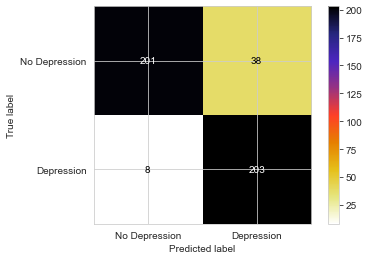

In [340]:
# finding the optimum weights

predictions = []
for clff in clfs:
    predictions.append(clff.predict_proba(X_test))

def log_loss_func(weights):
    final_prediction = 0
    for weight, prediction in zip(weights, predictions):
            final_prediction += weight*prediction

    return log_loss(y_test, final_prediction)

#the algorithms need a starting value, right now we have selected 0.5 for all weights
#its better to choose many random starting points and run minimize a few times
starting_values = [0.5]*len(predictions)

cons = ({'type':'eq','fun':lambda w: 1-sum(w)})
#our weights are bound between 0 and 1
bounds = [(0,1)]*len(predictions)

res = minimize(log_loss_func, starting_values, method='SLSQP', bounds=bounds, constraints=cons)

#print('Best Weights: {weights}'.format(weights=res['x']))

weighted_avg = VotingClassifier(estimators, voting='soft', weights=res['x']).fit(X_train, y_train)

plot_confusion_matrix(weighted_avg, X_test, y_test, cmap='CMRmap_r', display_labels=['No Depression', 'Depression'])

weighted_avg_predictions = weighted_avg.predict(X_test)

print(confusion_matrix(y_test, weighted_avg_predictions))
print('\n')
print(classification_report(y_test, weighted_avg_predictions))

y_probas_wa = weighted_avg.predict(X_test)

print('ROC-AUC Score:', round(roc_auc_score(y_test, y_probas_wa), 3))